In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
from analysis import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
from scipy import stats

In [ ]:
%%time
# ~18mins

# Execute CURATE without pop tau
execute_CURATE()

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

In [48]:
# Profile Generation
input_file = 'Retrospective Liver Transplant Data.xlsx'
rows_to_skip = 17

# Get list of patients/sheet names
list_of_patients = get_sheet_names(input_file)

# Define lists
list_of_patient_df = []
list_of_cal_pred_df = []
list_of_result_df = []
patients_to_exclude_linear = []
patients_to_exclude_quad = []
list_of_body_weight = []

# Create list of body_weight
for i in range(len(list_of_patients)):    
    data = pd.read_excel('Retrospective Liver Transplant Data.xlsx', list_of_patients[i], index_col=None, usecols = "C", nrows=15)
    data = data.reset_index(drop=True)
    list_of_body_weight.append(data['Unnamed: 2'][13])
    
list_of_body_weight = list_of_body_weight[:12]+[8.29]+list_of_body_weight[12+1:]

number_of_patients = 0

for patient in list_of_patients:

    # Create and clean patient dataframe        
    df = pd.read_excel(input_file, sheet_name=patient, skiprows=rows_to_skip)
    df = clean_data(df, patient)
    df = keep_ideal_data(df, patient, list_of_patient_df)
    
    # Change to dose by body weight
    df['dose'] = df['dose'] / list_of_body_weight[number_of_patients - 1]
    
    # Counter for number of patients
    number_of_patients = number_of_patients + 1
    
list_of_patient_df

[   day response      dose patient
 2  2.0      2.4  0.027100      84
 3  3.0      2.8  0.054201      84
 4  4.0      3.2  0.081301      84
 5  5.0      3.1  0.081301      84
 6  6.0      7.9  0.162602      84
 7  7.0       10  0.162602      84
 8  8.0     10.3  0.162602      84,
      day response      dose patient
 5    5.0      4.6  0.206186     114
 6    6.0      6.2  0.257732     114
 7    7.0     10.8  0.309278     114
 8    8.0      5.8  0.309278     114
 9    9.0     11.3  0.360825     114
 10  10.0      7.5  0.206186     114
 11  11.0      6.8  0.206186     114
 12  12.0        3  0.103093     114
 13  13.0      4.3  0.206186     114
 14  14.0      6.1  0.309278     114
 15  15.0      4.6  0.309278     114
 16  16.0        3  0.360825     114
 17  17.0      8.6  0.360825     114
 18  18.0      6.8  0.412371     114
 19  19.0      9.2  0.412371     114
 20  20.0      7.6  0.412371     114,
      day response      dose patient
 9    9.0      9.7  0.235018     117
 10  10.0      

In [47]:


list_of_body_weight

[9.7,
 8.51,
 11.7,
 48,
 9.38,
 50.2,
 11,
 11.1,
 13.5,
 14,
 30,
 19.6,
 8.29,
 8.5,
 34.75,
 18.45]

C:\Users\tshibei\AppData\Local\Temp/ipykernel_13744/3100586809.py:36: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(plot)


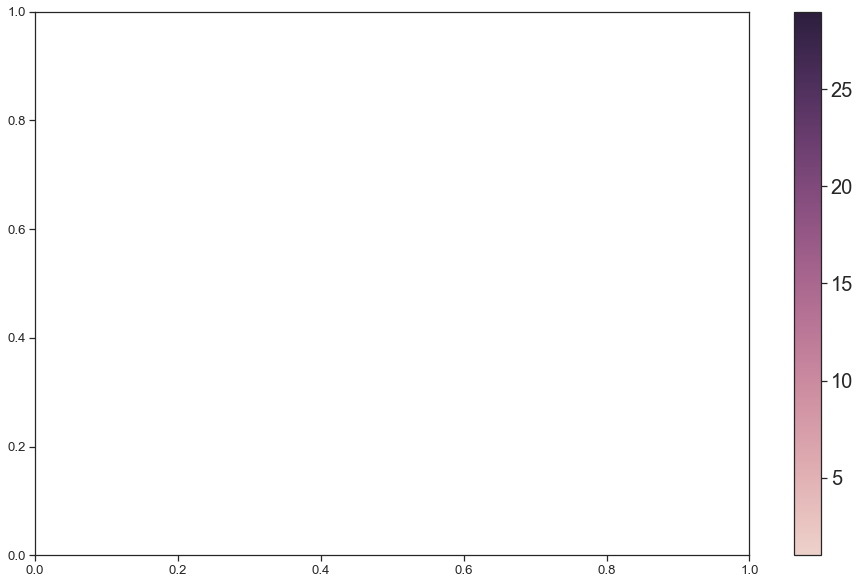

In [21]:
file_string='all_data_including_non_ideal.xlsx'
plot=True

# Plot individual profiles
dat = pd.read_excel(file_string, sheet_name='clean')

# Create within-range column for color
dat['within_range'] = (dat.response <= 10) & (dat.response >= 8)

# Create low/med/high dose column
dat['dose_range'] = ""
for i in range(len(dat)):
    if dat.dose[i] < 2:
        dat.loc[i, 'dose_range'] = 'Low'
    elif dat.dose[i] < 4:
        dat.loc[i, 'dose_range'] = 'Medium'
    else:
        dat.loc[i, 'dose_range'] = 'High'

# Rename columns and entries
new_dat = dat.copy()
new_dat = new_dat.rename(columns={'within_range':'Tacrolimus Levels'})
new_dat['Tacrolimus Levels'] = new_dat['Tacrolimus Levels'].map({True:'Therapeutic Range', False: 'Non-therapeutic Range'})
new_dat = new_dat.rename(columns={'dose_range':'Dose range', 'day':'Day'})
new_dat['patient'] = new_dat['patient'].map({84:1, 114:2, 117:3, 118:4, 120:5, 121:6, 122:7,
                                            123:8, 125:9, 126:10, 129:11, 130:12, 131:13, 132:14,
                                            133:15, 138:16})

if plot == True:

    # Plot dose vs response
    sns.set(font_scale=1.2, rc={"figure.figsize": (16,10), "xtick.bottom" : True, "ytick.left" : True}, style='white')

    plot = plt.scatter(new_dat.dose, new_dat.response, c=new_dat.Day, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.clf()
    cbar = plt.colorbar(plot)
    cbar.ax.tick_params(labelsize=20) 

    plt.savefig('colorbar.png', dpi=500, facecolor='w', bbox_inches='tight')

#     g = sns.relplot(data=new_dat, x='dose', y='response', hue='Day', col='patient', col_wrap=4, style='Dose range',
#             height=3, aspect=1,s=80)

#     # Add gray region for therapeutic range
#     for ax in g.axes:
#         ax.axhspan(8, 10, facecolor='grey', alpha=0.2)
        
#     g.set_titles('Patient {col_name}')
#     g.set_ylabels('Tacrolimus level (ng/ml)')
#     g.set_xlabels('Dose')
#     g.set(yticks=np.arange(0,math.ceil(max(new_dat.response)),4),
#         xticks=np.arange(0, max(new_dat.dose+1), step=1))

#     plt.savefig('indiv_pt_profile_by_dose.png', dpi=500, facecolor='w', bbox_inches='tight')

In [ ]:
dat = df.copy()
# dat[(dat.Method=='RW') & (dat.Dataset=='Test')].describe()

# Subset RW
dat = dat[dat.method=='L_RW_wo_origin'].reset_index(drop=True)

dat['recommended_dose'] = [7.5, 7.5, 2.5, 2.5, 4.5, 8, 5.5, 5, 5, 2, 7, 3.3]